# 구내식당 식수 인원 예측 AI 경진대회

### 1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from xgboost import XGBRegressor

In [2]:
path = "/content/drive/MyDrive/Dacon/튜토리얼/data/구내식당_식사인원_예측_data/"

In [3]:
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
submission = pd.read_csv(path + "sample_submission.csv")

### 2. 데이터 살펴보기

데이터 설명

 - 일자 --> date
 - 요일 --> dow
 - 본사정원수 --> employees
 - 본사휴가자수 --> vacation
 - 본사출장자수 --> bustrip
 - 시간외근무명령서승인건수 --> overtime
 - 현본사소속재택근무자수 --> home
 - 조식메뉴 --> breakfast
 - 중식메뉴 --> lunch
 - 석식메뉴 --> dinner
 - **중식계  (타깃)** --> target_lunch
 - **석식계 (타깃)** --> target_dinner

In [4]:
# 칼럼명 영어로 수정

train.columns = ['date', 'dow', 'employees', 'vacation', 'bustrip', 'overtime', 'home', 'break', 'lunch', 'dinner', 'target_lunch', 'target_dinner']

test.columns = ['date', 'dow', 'employees', 'vacation', 'bustrip', 'overtime', 'home', 'break', 'lunch', 'dinner']
train.head(2)

,date,dow,employees,vacation,bustrip,overtime,home,break,lunch,dinner,target_lunch,target_dinner
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [5]:
test.head(2)

,date,dow,employees,vacation,bustrip,overtime,home,break,lunch,dinner
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [6]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [7]:
# 각 요일을 1,2,3,4,5로 mapping 하기
train['dow'] = train['date'].dt.weekday + 1
test['dow'] = test['date'].dt.weekday + 1

휴가자, 출장자, 재택근무자 뺀 인원이 구내식당을 사용할 수 있는 인원이므로 모두 빼주자.

In [8]:
train['employees'] = train['employees'] - train['vacation'] - train['bustrip'] - train['home']
test['employees'] = test['employees'] - test['vacation'] - test['bustrip'] - test['home']

drops = ['vacation', 'bustrip', 'home']
train.drop(drops, axis=1, inplace=True)
test.drop(drops, axis=1, inplace=True)

In [9]:
# 조식메뉴는 불필요하다고 생각하여 제거

train.drop(['break'], axis=1, inplace=True)
test.drop(['break'], axis=1, inplace=True)

In [10]:
train.head(2)

,date,dow,employees,overtime,lunch,dinner,target_lunch,target_dinner
0,2016-02-01,1,2401.0,238,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,2,2378.0,319,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


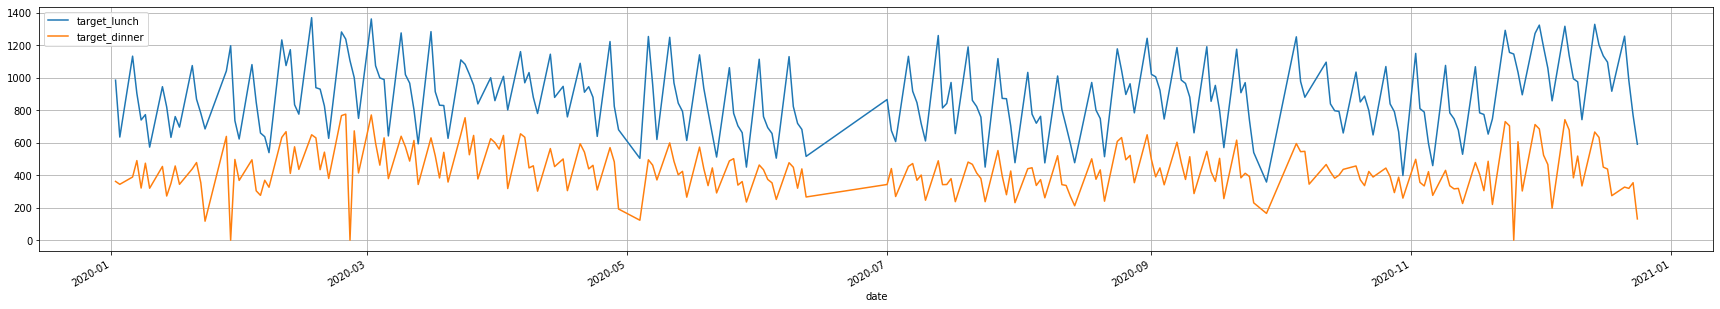

In [11]:
# 시계열 데이터 시각화
train[train['date'].dt.year==2020].plot(x='date', y=['target_lunch', 'target_dinner'], figsize=(30,5), grid=True)
plt.show()

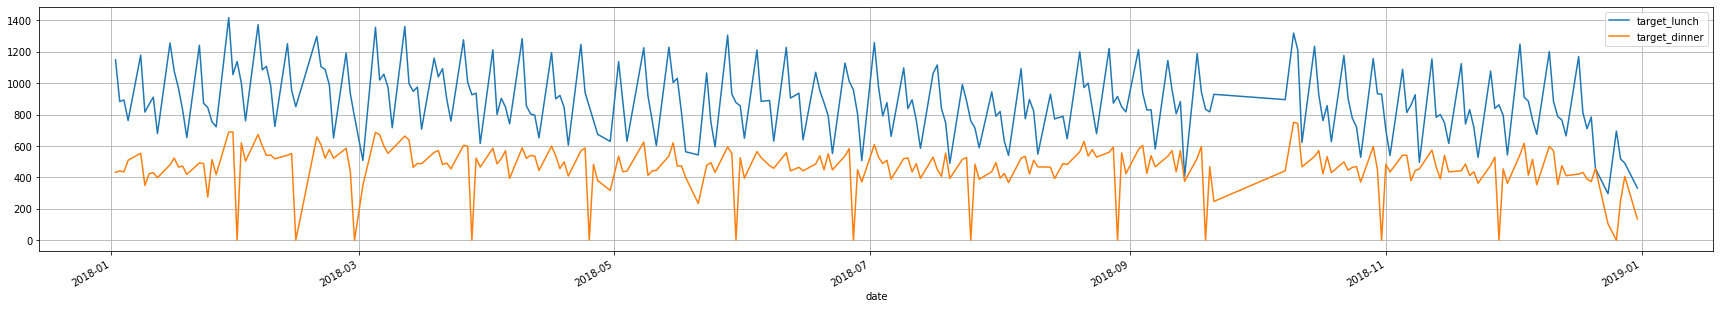

In [12]:
train[train['date'].dt.year==2018].plot(x='date', y=['target_lunch', 'target_dinner'], figsize=(30,5), grid=True)
plt.show()

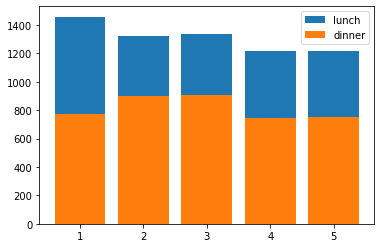

In [13]:
# 요일별 target값
plt.bar(train['dow'], train['target_lunch'], label='lunch')
plt.bar(train['dow'], train['target_dinner'], label='dinner')
plt.legend()
plt.show()

In [16]:
# 월, 일 칼럼 추가
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

train['day'] = train['date'].dt.day
test['day'] = test['date'].dt.day

In [18]:
train.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

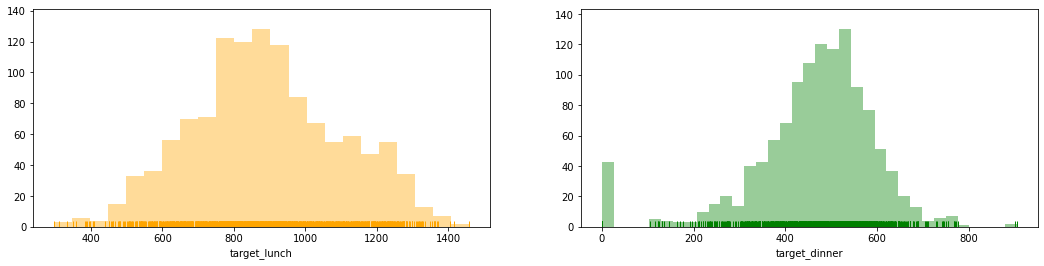

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
sns.distplot(train["target_lunch"], ax = ax[0], color = 'orange', kde = False, rug = True)
sns.distplot(train["target_dinner"], ax = ax[1], color = 'green', kde = False, rug = True)
plt.show()

석식계가 0인 데이터가 좀 있음.

오류로 보이기 때문에 살펴보자.

중식계 예측 모델과 석식계 예측 모델을 따로 하는 것이 좋을 것 같다.

In [20]:
len(train[train['target_dinner']==0])

43

In [21]:
train[train['target_dinner']==0][39:44]

,dow,employees,overtime,lunch,dinner,target_lunch,target_dinner,month,day
955,2,2253.0,22,쌀밥/잡곡밥 (쌀:국내산) 배추된장국 닭볶음탕 (닭:국내산) 부추깻잎전 양배추쌈...,*,349.0,0.0,12,31
973,3,2506.0,4,"콩나물밥*양념장 (쌀:국내산,소고기:호주) 가쯔오장국 치킨핑거 (닭:국내산) 꽃맛...",자기개발의날,1197.0,0.0,1,29
993,3,2573.0,4,"낙지비빔밥 (쌀:국내,낙지:중국산) 팽이장국 치킨텐더*콘소스D (닭:국내산) 과일...",자기개발의날,1105.0,0.0,2,26
1166,3,2237.0,3,쌀밥/흑미밥/찰현미밥 콩비지김치찌개 해물누룽지탕 탕평채 고추장감자조림 깍두기/수제과...,＜자기 계발의 날＞,1146.0,0.0,11,25


train 데이터에 석식메뉴가 없는 경우가 있다.



In [22]:
# 중식 데이터과 석식 데이터 분리
train_lunch = train.copy()
train_dinner = train.copy()

test_lunch = test.copy()
test_dinner = test.copy()

train_lunch.drop(['dinner', 'target_dinner'], axis=1, inplace=True)
train_dinner.drop(['lunch', 'target_lunch'], axis=1, inplace=True)

test_lunch.drop(['dinner'], axis=1, inplace=True)
test_dinner.drop(['lunch'], axis=1, inplace=True)

In [23]:
# 석식 데이터에서 석식메뉴가 없는 날 삭제
drops = train_dinner[train_dinner['target_dinner']==0].index

train_dinner.drop(drops, axis=0, inplace=True)
train_dinner.reset_index(drop=True, inplace=True)

In [24]:
# 석식메뉴는 표기안되었지만 target값은 있는 행도 삭제
train_dinner.iloc[[565]]

,dow,employees,overtime,dinner,target_dinner,month,day
565,5,2245.0,50,*,448.0,6,22


In [25]:
train_dinner.drop(565, axis=0, inplace=True)
train_dinner.reset_index(drop=True, inplace=True)

In [26]:
# train에서 중식메뉴와 석식메뉴 뽑아내기

train_lunch_menu = []
for i in range(len(train_lunch)):
    tmp = train_lunch.loc[i, 'lunch'].split()

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    train_lunch_menu.append(tmp[:3])

train_dinner_menu = []
for i in range(len(train_dinner)):
    tmp = train_dinner.loc[i, 'dinner'].split()

    for menu in tmp:
        if '(' in menu:     # 원산지 필요 x
            tmp.remove(menu)
    train_dinner_menu.append(tmp[:3])

- 밥 -> 국 -> 반찬 순으로 되어있지만, 반찬 중에서 메인 반찬 (3번째 메뉴)에 의해 구내식당에서 식사 여부가 결정될 것이라고 예상해서 3번째 메뉴까지만 뽑아내고 나머지는 버림

In [27]:
# train에 rice, soup, main_menu 칼럼 추가
rice = []
soup = []
main_menu = []

for menu in train_lunch_menu:
    rice.append(menu[0])
    soup.append(menu[1])
    main_menu.append(menu[2])

train_lunch['rice'] = rice
train_lunch['soup'] = soup
train_lunch['main_menu'] = main_menu

rice = []
soup = []
main_menu = []

for menu in train_dinner_menu:
    rice.append(menu[0])
    soup.append(menu[1])
    main_menu.append(menu[2])

train_dinner['rice'] = rice
train_dinner['soup'] = soup
train_dinner['main_menu'] = main_menu

test에도 전처리 적용

In [28]:
# test에서 중식메뉴와 석식메뉴 뽑아내기

test_lunch_menu = []
for i in range(len(test_lunch)):
    tmp = test_lunch.loc[i, 'lunch'].split()

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    test_lunch_menu.append(tmp[:3])

test_dinner_menu = []
for i in range(len(test_dinner)):
    tmp = test_dinner.loc[i, 'dinner'].split()

    for menu in tmp:
        if '(' in menu:     # 원산지 필요 x
            tmp.remove(menu)
    test_dinner_menu.append(tmp[:3])

In [29]:
# test에 rice, soup, main_menu 칼럼 추가
rice = []
soup = []
main_menu = []

for menu in test_lunch_menu:
    rice.append(menu[0])
    soup.append(menu[1])
    main_menu.append(menu[2])

test_lunch['rice'] = rice
test_lunch['soup'] = soup
test_lunch['main_menu'] = main_menu

rice = []
soup = []
main_menu = []

for menu in test_dinner_menu:
    rice.append(menu[0])
    soup.append(menu[1])
    main_menu.append(menu[2])

test_dinner['rice'] = rice
test_dinner['soup'] = soup
test_dinner['main_menu'] = main_menu

In [30]:
train_lunch.drop(['lunch'], axis=1, inplace=True)
train_dinner.drop(['dinner'], axis=1, inplace=True)

In [31]:
test_lunch.drop(['lunch'], axis=1, inplace=True)
test_dinner.drop(['dinner'], axis=1, inplace=True)

In [32]:
train_lunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dow           1205 non-null   int64  
 1   employees     1205 non-null   float64
 2   overtime      1205 non-null   int64  
 3   target_lunch  1205 non-null   float64
 4   month         1205 non-null   int64  
 5   day           1205 non-null   int64  
 6   rice          1205 non-null   object 
 7   soup          1205 non-null   object 
 8   main_menu     1205 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 84.9+ KB


In [33]:
# 범주형 자료형으로 변환
train_lunch['rice'] = train_lunch['rice'].astype('category')
train_dinner['rice'] = train_dinner['rice'].astype('category')
train_lunch['rice'] = train_lunch['rice'].cat.codes
train_dinner['rice'] = train_dinner['rice'].cat.codes

train_lunch['soup'] = train_lunch['soup'].astype('category')
train_dinner['soup'] = train_dinner['soup'].astype('category')
train_lunch['soup'] = train_lunch['soup'].cat.codes
train_dinner['soup'] = train_dinner['soup'].cat.codes

train_lunch['main_menu'] = train_lunch['main_menu'].astype('category')
train_dinner['main_menu'] = train_dinner['main_menu'].astype('category')
train_lunch['main_menu'] = train_lunch['main_menu'].cat.codes
train_dinner['main_menu'] = train_dinner['main_menu'].cat.codes


# test 데이터에도 적용
test_lunch['rice'] = test_lunch['rice'].astype('category')
test_dinner['rice'] = test_dinner['rice'].astype('category')
test_lunch['rice'] = test_lunch['rice'].cat.codes
test_dinner['rice'] = test_dinner['rice'].cat.codes

test_lunch['soup'] = test_lunch['soup'].astype('category')
test_dinner['soup'] = test_dinner['soup'].astype('category')
test_lunch['soup'] = test_lunch['soup'].cat.codes
test_dinner['soup'] = test_dinner['soup'].cat.codes

test_lunch['main_menu'] = test_lunch['main_menu'].astype('category')
test_dinner['main_menu'] = test_dinner['main_menu'].astype('category')
test_lunch['main_menu'] = test_lunch['main_menu'].cat.codes
test_dinner['main_menu'] = test_dinner['main_menu'].cat.codes

In [34]:
train_dinner.head(3)

,dow,employees,overtime,target_dinner,month,day,rice,soup,main_menu
0,1,2401.0,238,331.0,2,1,65,222,339
1,2,2378.0,319,560.0,2,2,109,181,333
2,3,2365.0,111,573.0,2,3,65,242,428


In [35]:
test_dinner.head(3)

,dow,employees,overtime,month,day,rice,soup,main_menu
0,3,2355.0,5,1,27,14,32,25
1,4,2319.0,409,1,28,12,34,35
2,5,2170.0,0,1,29,14,14,44


In [36]:
train_lunch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dow           1205 non-null   int64  
 1   employees     1205 non-null   float64
 2   overtime      1205 non-null   int64  
 3   target_lunch  1205 non-null   float64
 4   month         1205 non-null   int64  
 5   day           1205 non-null   int64  
 6   rice          1205 non-null   int8   
 7   soup          1205 non-null   int16  
 8   main_menu     1205 non-null   int16  
dtypes: float64(2), int16(2), int64(4), int8(1)
memory usage: 62.5 KB


In [37]:
y_train_lunch = train_lunch['target_lunch']
y_train_dinner = train_dinner['target_dinner']

train_lunch.drop(['target_lunch'], axis=1, inplace=True)
train_dinner.drop(['target_dinner'], axis=1, inplace=True)

In [38]:
model_lunch = XGBRegressor()
model_dinner = XGBRegressor()

model_lunch.fit(train_lunch, y_train_lunch)
model_dinner.fit(train_dinner, y_train_dinner)

[05:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [39]:
pred_lunch = model_lunch.predict(test_lunch)
pred_dinner = model_dinner.predict(test_dinner)

In [40]:
submission['중식계'] = pred_lunch
submission['석식계'] = pred_dinner

In [41]:
submission.to_csv('XGBRegressor.csv', index=False)